# 4 利用Pytorch实现softmax回归的简洁实现

In [91]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

print(torch.__version__)

2.0.0+cu118


## 4.1 加载图像分类数据集（Fashion-MNIST）

In [92]:
mnist_train = torchvision.datasets.FashionMNIST(root='./dataset/FashionMNIST', train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='./dataset/FashionMNIST', train=False, download=False, transform=transforms.ToTensor())

In [93]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [94]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

C:\Users\crc\AppData\Local\Temp\ipykernel_15888\1295271808.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


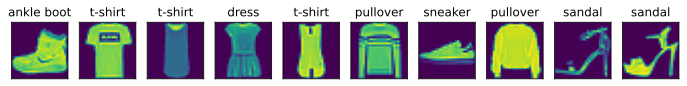

In [95]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
from IPython import display
def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')
def show_fashion_mnist(images, labels):
    use_svg_display()
    # 杩欓噷鐨刜琛ㄧず鎴戜滑蹇界暐锛堜笉浣跨敤锛夌殑鍙橀噺
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 4.2 获取和读取数据
可选择不同的batch_size

In [96]:
batch_size = 32
num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## 4.3 定义和初始化模型

In [97]:
num_inputs = 784
num_hidden_layer = 256
num_outputs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#定义模型（添加）
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden_layer=None):
        super(LinearNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden_layer),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden_layer,num_outputs)
            # nn.Linear(num_inputs, num_outputs),
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='leaky_relu')
                layer.bias.data.fill_(0)


    def forward(self, x):  # x shape: (batch, 1, 28, 28)
        x = x.view(x.shape[0], -1)
        output = self.net(x)
        return output

       
net = LinearNet(num_inputs, num_outputs, num_hidden_layer)
net = net.to(device)


In [98]:
#输出初始化的参数（添加）
for name, param in net.named_parameters():
    if 'weight' in name:
        print(f'Parameter {name}: {param}')

Parameter net.0.weight: Parameter containing:
tensor([[ 0.0222,  0.0897,  0.0071,  ..., -0.0144, -0.0682,  0.0205],
        [ 0.0009, -0.0097,  0.0041,  ..., -0.0048,  0.0739, -0.0885],
        [ 0.0063, -0.0087, -0.0428,  ..., -0.1058, -0.0049,  0.0112],
        ...,
        [-0.0795, -0.0115,  0.0776,  ...,  0.0044, -0.1059, -0.0073],
        [-0.0182,  0.0790, -0.1556,  ..., -0.0521, -0.0126,  0.0272],
        [-0.0933,  0.0218, -0.1033,  ..., -0.0800, -0.0592,  0.1017]],
       device='cuda:0', requires_grad=True)
Parameter net.3.weight: Parameter containing:
tensor([[ 0.0784, -0.0176,  0.1307,  ...,  0.0271, -0.0005, -0.0128],
        [-0.0838,  0.1095, -0.0407,  ...,  0.1144, -0.1334, -0.0891],
        [ 0.1020,  0.0545, -0.1395,  ..., -0.1114, -0.0648, -0.0306],
        ...,
        [-0.0453, -0.0176,  0.1521,  ..., -0.2201,  0.0820,  0.0783],
        [ 0.0943,  0.0122,  0.0711,  ..., -0.0745, -0.1898,  0.0185],
        [ 0.0391, -0.1212, -0.0060,  ...,  0.0190, -0.0467,  0.0323

## 4.4 softmax和交叉熵损失函数

In [99]:
loss = nn.CrossEntropyLoss().to(device)
# loss = nn.MSELoss().to(device)
# loss = nn.L1Loss().to(device)

## 4.5 定义优化算法
可选择多种优化算法训练模型(查官网资料)

可选择不同的学习率

In [100]:
import torch.optim as optim

learning_rate = 0.001
# optimizer = optim.SGD(net.parameters(), lr=learning_rate)
# optimizer = optim.Adagrad(net.parameters(), lr=learning_rate)# Adagrad梯度下降
optimizer = optim.Adam(net.parameters(), lr=learning_rate)# Adam梯度下降
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## 4.6 训练模型

## 定义评价函数代码

In [101]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

## 模型训练过程 代码（添加）
可选择不同epoch大小
训练过程代码自行添加

In [102]:
num_epochs = 20

losses = []
accuracies = []
accuracies_train = []
accuracies_test = []

for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_l_sum += l.cpu().item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
        n += y.shape[0]

    losses.append(train_l_sum / n)
    train_acc = evaluate_accuracy(train_iter, net, "cuda")
    test_acc = evaluate_accuracy(test_iter, net, "cuda")
    accuracies_train.append(train_acc)
    accuracies_test.append(test_acc)

    accuracies.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
          % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))


epoch 1, loss 0.0182, train acc 0.794, test acc 0.842
epoch 2, loss 0.0140, train acc 0.837, test acc 0.845
epoch 3, loss 0.0130, train acc 0.848, test acc 0.863
epoch 4, loss 0.0124, train acc 0.856, test acc 0.864
epoch 5, loss 0.0120, train acc 0.859, test acc 0.871
epoch 6, loss 0.0116, train acc 0.864, test acc 0.868
epoch 7, loss 0.0113, train acc 0.867, test acc 0.873
epoch 8, loss 0.0110, train acc 0.871, test acc 0.872
epoch 9, loss 0.0108, train acc 0.873, test acc 0.876
epoch 10, loss 0.0107, train acc 0.875, test acc 0.876
epoch 11, loss 0.0105, train acc 0.876, test acc 0.870
epoch 12, loss 0.0103, train acc 0.878, test acc 0.880
epoch 13, loss 0.0101, train acc 0.881, test acc 0.875
epoch 14, loss 0.0101, train acc 0.881, test acc 0.881
epoch 15, loss 0.0099, train acc 0.882, test acc 0.882
epoch 16, loss 0.0098, train acc 0.884, test acc 0.879
epoch 17, loss 0.0097, train acc 0.884, test acc 0.876
epoch 18, loss 0.0097, train acc 0.883, test acc 0.877
epoch 19, loss 0.00

后来想再刷一刷点，结果把最高的点没保存qwq，代码里只有这个了

## 4.7 训练过程可视化
参考线性回归的代码展现可视化过程，loss以及准确率的变化图

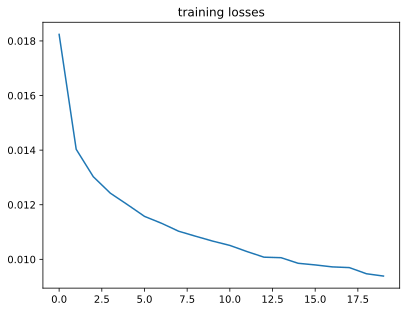

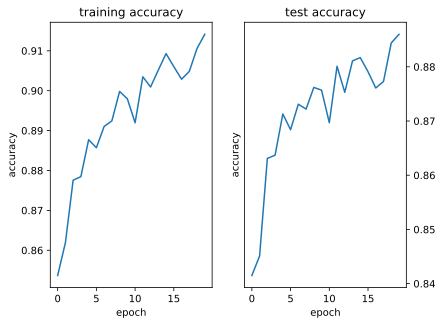

In [103]:
# 训练过程可视化
plt.plot(losses)
plt.title("training losses")
plt.savefig("./results/loss.png") #保存loss图片
plt.show()
plt.subplot(121)#创建子图1
plt.plot(accuracies_train)
plt.title("training accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.subplot(122)  # 创建子图2
plt.plot(accuracies_test)
plt.title("test accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
ax=plt.gca()
ax.yaxis.tick_right()
plt.savefig("./results/accuracy.png")